# Malleco data
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>

In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/src')

from src.utils import *
from src.kernels import Kernel

from scipy.stats import wasserstein_distance

init_notebook_mode(connected=True) ## plotly init
seed = 123
random.seed = seed

import os
path_data = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/data/"

/Users/mzalaya/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
malleco = pd.read_csv(path_data + 'malleco.csv')

In [3]:
malleco.head(), malleco.columns

(   Year Value
 0  1242 1.343
 1  1243 1.044
 2  1244 1.174
 3  1245 1.068
 4  1246 0.913,
 Index(['Year Value'], dtype='object'))

In [4]:
years = []
values = []
for i in range(malleco.shape[0]):
    years.append(malleco['Year Value'][i][:4])
    values.append(malleco['Year Value'][i][5:])
    
df_malleco = pd.DataFrame({'Year': years, 'Value': values})

In [5]:
df_malleco.head()

,Year,Value
0,1242,1.343
1,1243,1.044
2,1244,1.174
3,1245,1.068
4,1246,0.913


In [6]:
df_malleco['Value'] = pd.to_numeric(df_malleco['Value'])
df_malleco['Year'] = pd.to_numeric(df_malleco['Year'])

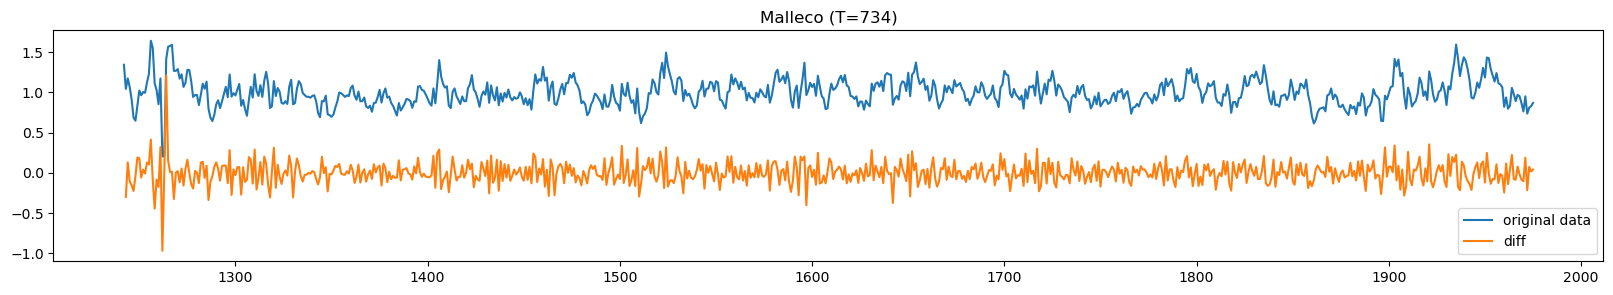

In [7]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_malleco['Year'], df_malleco['Value'], label="original data")
plt.plot(df_malleco['Year'], df_malleco['Value'].diff(), label="diff")
plt.legend()
plt.title("Malleco (T=734)")
plt.show()

In [8]:
df_malleco.shape

(734, 2)

In [9]:
# import pyreadr
# result = pyreadr.read_r(path_data + 'malleco.rda') # also works for Rds, rda
# print(result.keys()) 

In [10]:
df_malleco['Value'].values.reshape(-1, 1).shape

(734, 1)

In [12]:
# df_malleco['Value'].diff()
# values_array = []
# for i in range(df_malleco.shape[0]-1):
    # values_array.append(df_malleco['Value'][i+1] - df_malleco['Value'][i])

In [13]:
# values_array = np.array(values_array)
# values_array.size

In [14]:
np.where(df_malleco['Value'].diff() == np.nan)

(array([], dtype=int64),)

# Nadara-Watson estimator 

$$
h = C \times \frac{1}{T^{\xi}}
$$

In [56]:
# C = 6
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_malleco.shape[0]
d = 1
X_tvar_2 = df_malleco['Value'].values 
bandwidth = T **(-0.4 / (d+1)) * 1. / np.std(X_tvar_2) # * / 50
X_dict = df_malleco['Value'].values.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = df_malleco['Value'].values #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat = [np.sum(weights[str(t)] * X_tvar_2) for t in range(T)]

# Nadrawatson on the process not on its diff 

2024/06/03 23:42:59 Saved result in file Malleco-NW-Gaussian-sp-Uniform-time-C-50.pdf


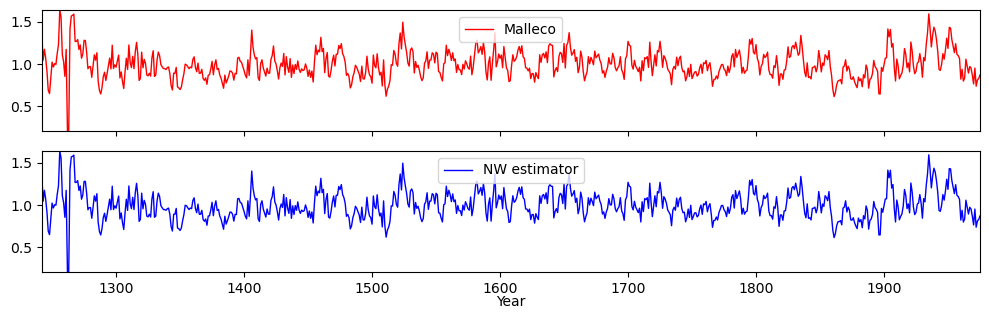

In [87]:
import logging

logging.basicConfig(
    format="%(asctime)s %(message)s", datefmt="%Y/%m/%d %H:%M:%S", level=logging.INFO
)

path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,3.3) , sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.02)
# plt.rcParams['axes.grid'] = True
# plt.rcParams['axes.facecolor'] = 'black'

output_filename = "Malleco-NW-Gaussian-sp-Uniform-time-C-50.pdf"
# from matplotlib.colors import ListedColormap
# cm = plt.cm.RdBu
# cm_bright = ListedColormap(["#FF0000", "#0000FF"])

ax[0].plot(df_malleco['Year'].values, X_tvar_2, lw=1, label="Malleco", color="#FF0000")  # #, color="r") #, cmap=cm)
ax[0].set_xlim(min(df_malleco['Year'].values), max(df_malleco['Year'].values))
ax[0].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[0].legend(loc='upper center')

ax[1].plot(df_malleco['Year'].values, np.array(m_hat), lw=1, label="NW estimator" , c="#0000FF")#cm_bright[0]) #"orange")
ax[1].set_xlim(min(df_malleco['Year'].values), max(df_malleco['Year'].values))
ax[1].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[1].legend(loc='upper center')
ax[1].set_xlabel("Year")
ax[1].xaxis.set_label_coords(0.5, -0.19)
plt.savefig(path_fig+output_filename, dpi=300)
plt.tight_layout()
# plt.show()
logging.info("Saved result in file %s" % output_filename)

In [85]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

np.sqrt(mse(np.array(m_hat), X_tvar_2)), mae(np.array(m_hat), X_tvar_2)

(0.0008914535818807643, 0.0004835809049098816)

In [57]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

np.sqrt(mse(np.array(m_hat), X_tvar_2)), mae(np.array(m_hat), X_tvar_2)

(0.16271433324709123, 0.12532282081262067)

In [61]:
8.914 *10**(-4), 4.835 *10**(-4)

(0.0008914, 0.00048350000000000004)

In [ ]:
(0.0013243158067462516, 0.0008385242139966689) # 40
(0.0008914535818807643, 0.0004835809049098816) # 50
# 60

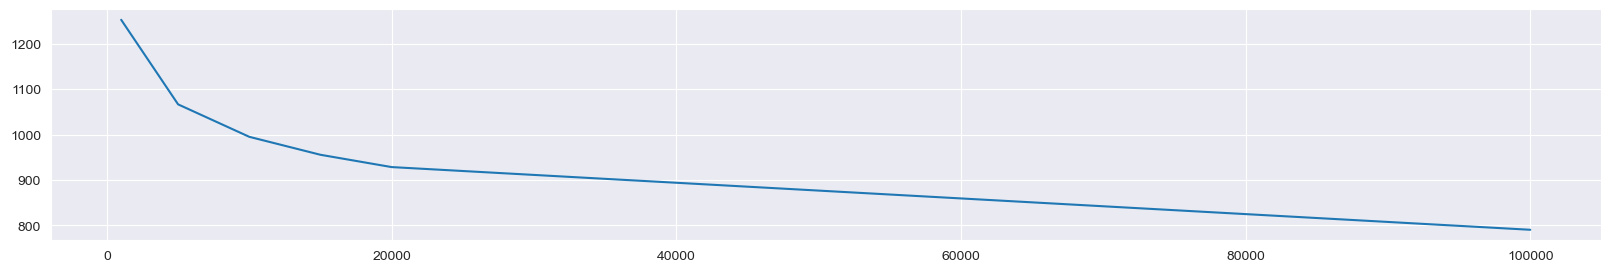

In [55]:
C = 50
T = np.array([1000, 5000, 10000, 15000, 20000, 100000])
bandwidth = T **(-0.4 / (d+1)) / C
plt.plot(T, 1 / (T**(1/2) * bandwidth**2), label="Bandwidth")

In [58]:
np.std(X_tvar_2)

0.16436202635115157